In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import pandas as pd
import math
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize
nltk.download('words')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm,tqdm_pandas
nltk.download('brown')
from nltk.corpus import brown
from nltk.corpus import stopwords
nltk.download('stopwords')

words = brown.words(categories="news")
sents = brown.sents(categories=["news"])

print("Number of words: ",len(words))
print("Number of sentences: ",len(sents))
print("Number of unique words (including capitalized)",
      len(set(words)))

[nltk_data] Downloading package words to /home/yui/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/yui/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to /home/yui/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of words:  100554
Number of sentences:  4623
Number of unique words (including capitalized) 14394


In [2]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag,wordnet.NOUN)

In [3]:
lem = WordNetLemmatizer()
def lemmWord(w):
    return lem.lemmatize(w,get_wordnet_pos(w))

In [4]:
w2id,id2w,idx={},{},2
eng = set(nltk.corpus.words.words())
w2id['<s>'],id2w[0]=0,'<s>'
w2id['<e>'],id2w[1]=1,'<e>'
newSents = []
for sent in tqdm(sents):
    newSent = [0]
    for word in sent:
        word = word.lower()
        word = lemmWord(word)
        if word in w2id:
            continue
        if word not in eng:
            continue
        if word in stopwords.words('english'):
            continue
        w2id[word]=idx
        id2w[idx]=word
        idx+=1
        newSent.append(w2id[word])
    newSent.append(1)
    newSents.append(newSent)

100%|██████████| 4623/4623 [00:08<00:00, 543.08it/s]


In [5]:
print("Number of unique words: ",len(w2id))

Number of unique words:  6432


In [6]:
V = len(w2id)
W = np.random.uniform(0,1,(V,V))
lr,epochs,losses = 1e-2,50,[]
for e in range(epochs):
    epochLosses = 0
    for sent in tqdm(newSents):
        L,loss = len(sent),0
        X = np.zeros((L-1,V))
        X[np.arange(L-1),np.array(sent[:-1])]=1
        Y = np.zeros((L-1,V))
        Y[np.arange(L-1),np.array(sent[1:])]=1
        tmp = X.dot(W)
        tmp -= tmp.max()
        tmp = np.exp(tmp)
        pred= tmp/tmp.sum(axis=1,keepdims=1)
        grad = X.T.dot(pred-Y)
        loss = -(Y*np.log(pred)).sum()
        W-=lr*grad
        epochLosses+=loss
    losses.append(epochLosses/len(newSents))

100%|██████████| 4623/4623 [09:55<00:00,  7.76it/s]


In [7]:
loss

17.691958996632906

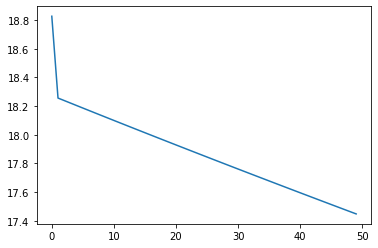

In [8]:
plt.plot(range(50),losses)

In [17]:
res,resfake = [],[]
for i,sent in enumerate(tqdm(newSents)):
    prev,logprob,logprobfake = 0,0,0
    T = len(sent)
    for j,word in enumerate(sent):
        if j==T-1:
            continue
        tmp = W[word]
        tmp -= tmp.max()
        tmp = np.exp(tmp)
        pred= tmp/tmp.sum()
        logprob+=np.log(pred[sent[j+1]])
    logprob/=T
    res.append(logprob)
    prev=0
    for wid in np.random.randint(1,len(w2id),T):
        tmp = W[prev]
        tmp -= tmp.max()
        tmp = np.exp(tmp)
        pred= tmp/tmp.sum()
        logprobfake+=np.log(pred[wid])
        prev = wid
    logprobfake/=T
    resfake.append(logprobfake)
    

100%|██████████| 4623/4623 [00:01<00:00, 3940.03it/s]


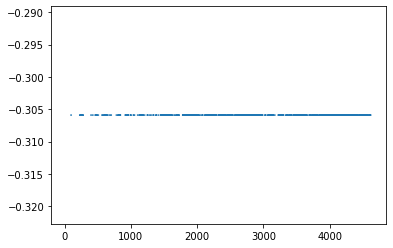

In [18]:
plt.plot(range(len(res)),res)
plt.plot(range(len(resfake)),resfake)

In [19]:
W[:10,:10]

array([[-9.05642081,  0.        , -8.43451886, -9.57494557, -9.24319075,
        -8.87179777, -9.01782978, -9.02173042, -9.31896181, -9.60615461],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan